In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [55]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

idx_train = (y_train == 0) |(y_train == 5) | (y_train == 7)
x_train = x_train[idx_train,:]
y_train = y_train[idx_train]
idx_test = (y_test == 0) |(y_test == 5) | (y_test == 7)
x_test = x_test[idx_test,:]
y_test = y_test[idx_test]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
cat_dim = 1
epochs = 20

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu', name='encoder_intermediate')(inputs)

# add 3 means as additional parameters
dummy = Input(shape=(latent_dim,), name='dummy')
mu1 = Dense(latent_dim, name='mu1')(dummy)
mu2 = Dense(latent_dim, name='mu2')(dummy)
mu3 = Dense(latent_dim, name='mu3')(dummy)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs,dummy], [z_mean, z_log_var, z, mu1, mu2, mu3], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder([inputs,dummy])[2])
vae = Model([inputs,dummy], outputs, name='vae_mlp')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
encoder_intermediate (Dense)    (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        encoder_intermediate[0][0]       
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        encoder_intermediate[0][0]       
__________________________________________________________________________________________________
dummy (Inp

In [56]:
models = (encoder, decoder)
data = (x_test, y_test)
dummy_train = np.ones((y_train.shape[0],2))
dummy_test  = np.ones((y_test.shape[0],2))

# reconstruction loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

# for each cluster KL divergence loss with respect to their own gaussian
d1 = K.exp(-K.sum(K.square(z-mu1), axis=-1)/2)
d2 = K.exp(-K.sum(K.square(z-mu2), axis=-1)/2)
d3 = K.exp(-K.sum(K.square(z-mu3), axis=-1)/2)
c1 = K.tf.divide(d1, d1 + d2 + d3)
c2 = K.tf.divide(d2, d1 + d2 + d3)
c3 = K.tf.divide(d3, d1 + d2 + d3)

kl_loss_1 = 1 + z_log_var - K.square(z_mean-mu1) - K.exp(z_log_var)
kl_loss_1 = K.tf.multiply(K.sum(kl_loss_1, axis=-1), c1)
kl_loss_2 = 1 + z_log_var - K.square(z_mean-mu2) - K.exp(z_log_var)
kl_loss_2 = K.tf.multiply(K.sum(kl_loss_2, axis=-1), c2)
kl_loss_3 = 1 + z_log_var - K.square(z_mean-mu3) - K.exp(z_log_var)
kl_loss_3 = K.tf.multiply(K.sum(kl_loss_3, axis=-1), c3)
kl_loss_1 *= -0.5
kl_loss_2 *= -0.5
kl_loss_3 *= -0.5

# plus KL divergence wrt q(c|x)
vae_loss = K.mean(reconstruction_loss+
                  kl_loss_1+kl_loss_2+kl_loss_3+
                  K.tf.multiply(c1,K.log(c1))+
                  K.tf.multiply(c2,K.log(c2))+
                  K.tf.multiply(c3,K.log(c3)))

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.load_weights('vae_mlp_mnist_template3.h5')
vae.fit([x_train,dummy_train],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test,dummy_test], None))
vae.save_weights('vae_mlp_mnist.h5')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dummy (InputLayer)              (None, 2)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 403990      encoder_input[0][0]              
                                                                 dummy[0][0]                      
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          403728      encoder[1][2]                    
Total para

(-4.3356906666977855, 4.477379013560579, -7.682964486107394, 8.314713639244601)

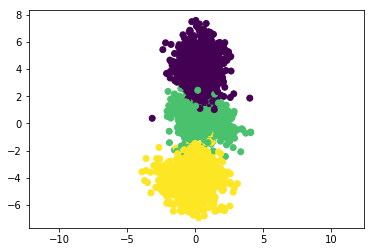

In [58]:
[z_mean, z_log_var, z, mu1, mu2, mu3] = encoder.predict([x_test,dummy_test],batch_size=batch_size)
d1 = np.exp(-np.sum(np.square(z-mu1), axis=-1)/2)
d2 = np.exp(-np.sum(np.square(z-mu2), axis=-1)/2)
d3 = np.exp(-np.sum(np.square(z-mu3), axis=-1)/2)
c1 = np.divide(d1, d1 + d2 + d3)
c2 = np.divide(d2, d1 + d2 + d3)
c3 = np.divide(d3, d1 + d2 + d3)

color = np.ones(y_test.shape[0])
for i in range(0, y_test.shape[0]):
    if c1[i] > c2[i] and c1[i] > c3[i]:
        color[i] = 0
    if c2[i] > c1[i] and c2[i] > c3[i]:
        color[i] = 2
        
# plot using ground truth label
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.axis('equal')